# Assignment 4

### Part A - Corner Detection

- Pick images of your choice which you feel should give a good output. Use above ones if you cannot find any else. Create or pick 3 images : one flat, one edge, one corner image. Examples shown above, you are free to you them too. Use the sobel kernels to find Ix and Iy ( or Gx and Gy whatever you call it ) and plot them. Then, create a scatter plot for Iy vs Ix. If you threshold, mention clearly that you have along with the threshold value too. Ideally make a function that takes the image and prints the graphs, also make the function return the Iy and Ix values for further questions. Hint: use grayscale only

In [449]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [450]:
local_img_path = 'flat_image.jpeg'
local_img_path_2 = 'edge_image.jpeg'
local_img_path_3 = 'corner_image.jpeg'

Sobel filters were used to compute horizontal (Ix) and vertical (Iy) gradients from grayscale images. 

In [451]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def corner_analysis(img_path, threshold=None):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if len(img.shape) == 3: 
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img.copy()

    gray = gray.astype(np.float32)

    Ix = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    Iy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)

    if threshold is not None:
        mag = np.sqrt(Ix**2 + Iy**2)
        mask = mag > threshold
        Ix_plot = Ix[mask]
        Iy_plot = Iy[mask]
    else:
        Ix_plot = Ix.flatten()
        Iy_plot = Iy.flatten()

    plt.figure(figsize=(15,4))

    plt.subplot(1,3,1)
    plt.imshow(Ix, cmap='gray')
    plt.title("Ix (Horizontal Gradient)")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(Iy, cmap='gray')
    plt.title("Iy (Vertical Gradient)")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.scatter(Ix_plot, Iy_plot, s=1)
    plt.xlabel("Ix")
    plt.ylabel("Iy")
    plt.title("Scatter Plot: Iy vs Ix")

    plt.tight_layout()
    plt.show()

    return Ix, Iy


Scatter plots of Iy vs Ix clearly differentiate flat regions, edges, and corners. 

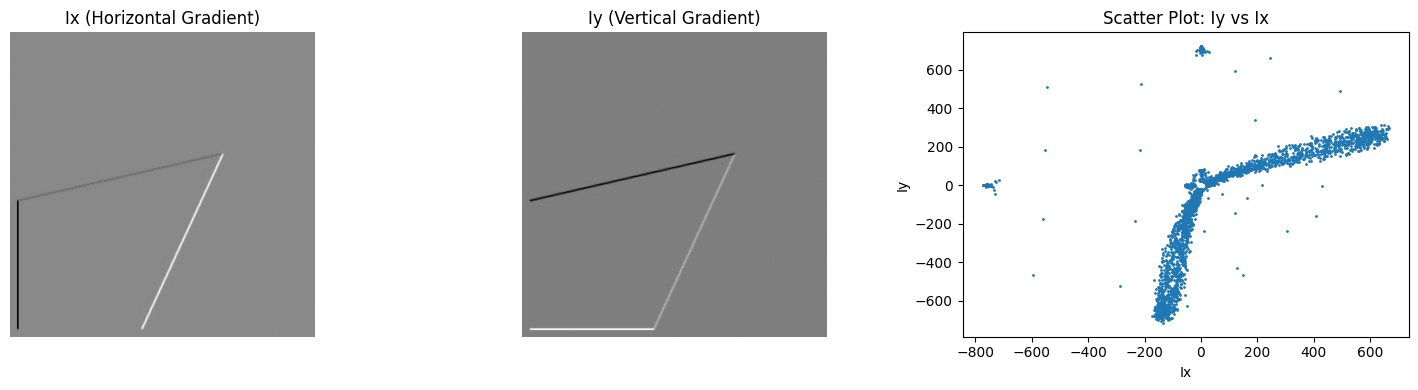

In [452]:
Ix_corner, Iy_corner = corner_analysis(local_img_path_3, threshold=20)

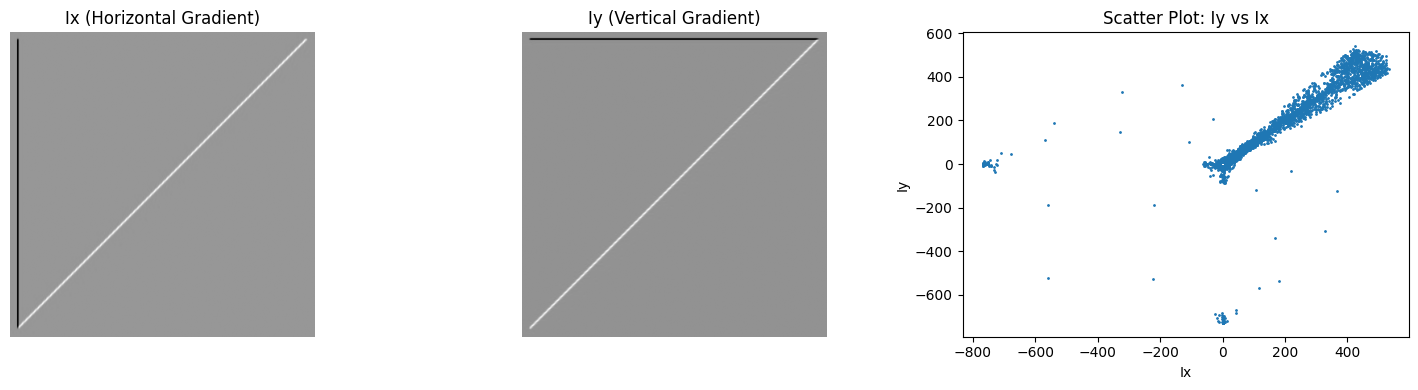

In [453]:
Ix_edge, Iy_edge = corner_analysis(local_img_path_2, threshold=10)

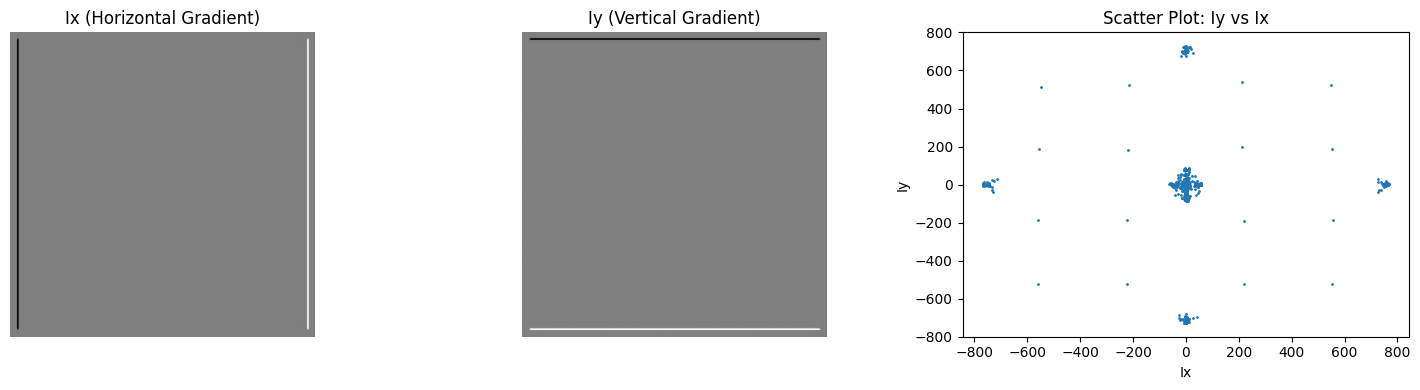

In [454]:
Ix_flat, Iy_flat = corner_analysis(local_img_path)

Flat regions show near-zero gradients, edges show dominant gradients in one direction, and corners exhibit strong gradients in both directions. 

### Part B - Ellipse Fitting and R Maps for Corner Detection

- Now, use the above functions ( basically Ix and Iy ) and the formulas in the pre-session videos to find values of a,b and c ( the second moments ) and calculate the eigenvalues lambda1 and lambda2. Then use those to create an R map for the entire image. Display the R map. Do it for the 3 images of part A. So, you might want to create a function that takes the image, loops over the pixels with a window, fits the ellipse over the window, calculates the lambdas, and value of R, essentially finding R values for all the pixels and returning an R-map ( a 2d image with only one channel where the value of a pixel is the r-value of that pixel in the original grayscale image ). Now, display these R maps. Notice how the corners are clearly visible in white

In [455]:
def compute_R_map(Ix, Iy, window_size=3, k=0.04):

    if len(Ix.shape) == 3:
        gray = cv2.cvtColor(Ix, cv2.COLOR_RGB2GRAY)
    else:
        gray = Ix.copy()

    gray = gray.astype(np.float32)

    Ix = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    Iy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)

    Ix2 = Ix * Ix
    Iy2 = Iy * Iy
    Ixy = Ix * Iy

    pad = window_size // 2
    h, w = gray.shape
    R_map = np.zeros((h, w), dtype=np.float32)

    # Sliding window
    for i in range(pad, h - pad):
        for j in range(pad, w - pad):
            a = np.sum(Ix2[i-pad:i+pad+1, j-pad:j+pad+1])
            b = np.sum(Ixy[i-pad:i+pad+1, j-pad:j+pad+1])
            c = np.sum(Iy2[i-pad:i+pad+1, j-pad:j+pad+1])

            det = a * c - b * b
            trace = a + c

            R_map[i, j] = det - k * (trace ** 2)

    return R_map


In [456]:
def show_R_map(R_map, title):
    R_norm = cv2.normalize(R_map, None, 0, 255, cv2.NORM_MINMAX)
    R_norm = R_norm.astype(np.uint8)

    plt.figure(figsize=(5,5))
    plt.imshow(R_norm, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

1. Gradient scatter gives ellipse
2. Eigenvalues provides the ellipse axis lengths
3. And Corners gives large ellipse in both axes

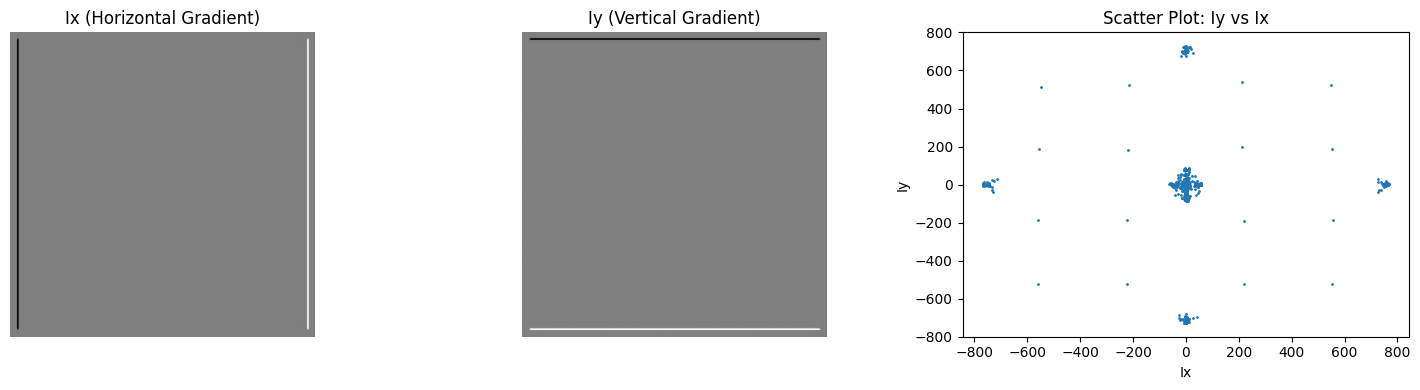

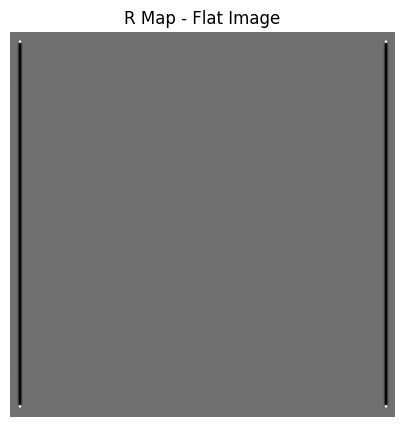

In [457]:
Ix_flat, Iy_flat = corner_analysis(local_img_path)
R_flat = compute_R_map(Ix_flat, Iy_flat)
show_R_map(R_flat, "R Map - Flat Image")


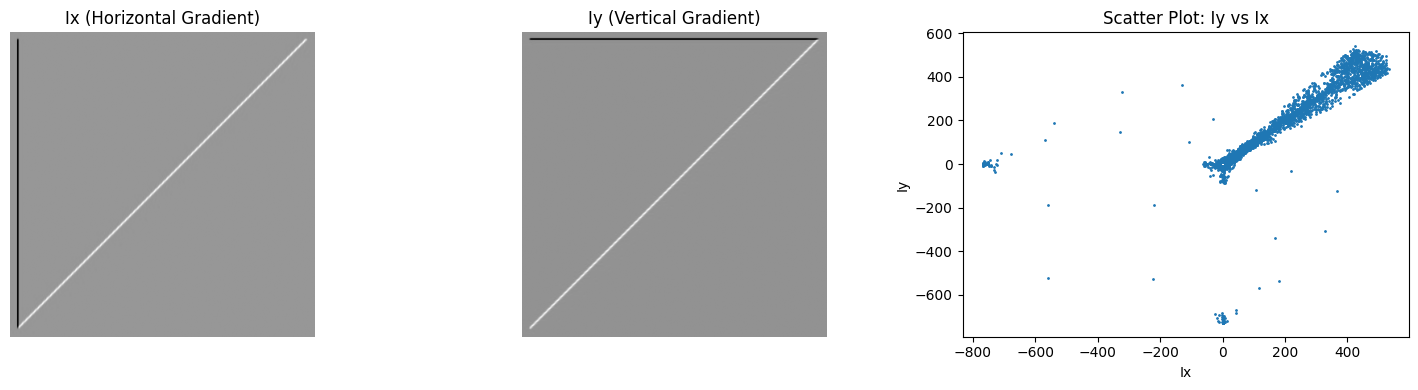

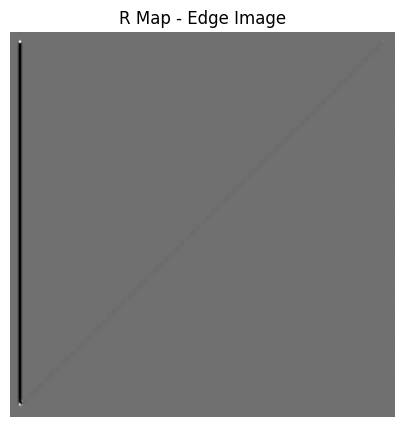

In [458]:
Ix_edge, Iy_edge = corner_analysis(local_img_path_2, threshold=10)
R_edge = compute_R_map(Ix_edge, Iy_edge)
show_R_map(R_edge, "R Map - Edge Image")

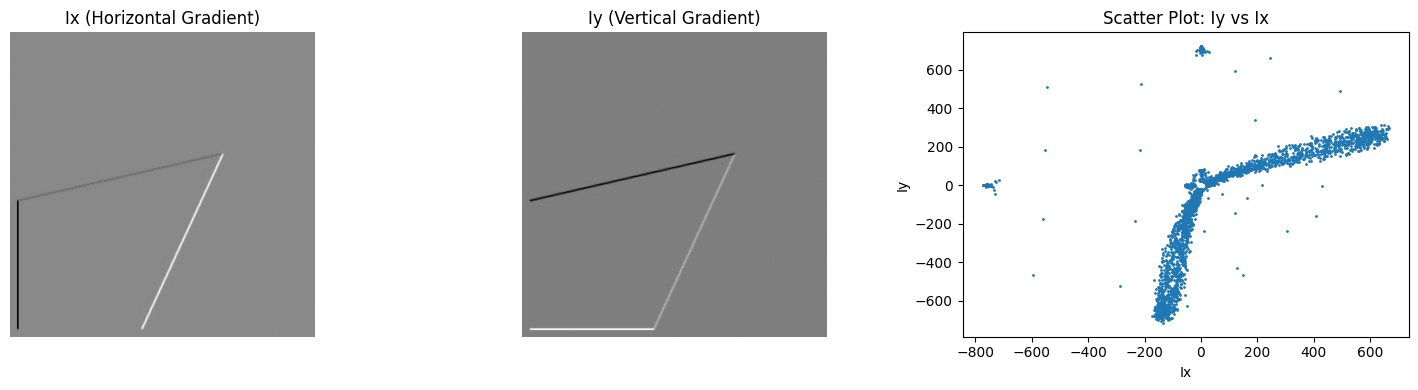

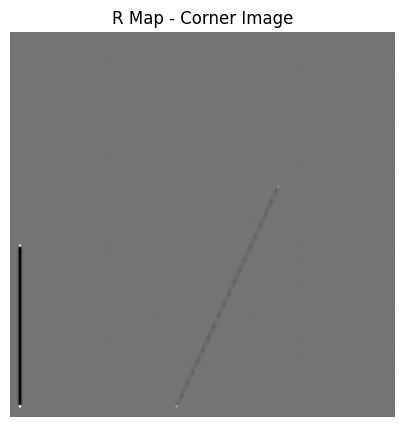

In [459]:
Ix_corner, Iy_corner = corner_analysis(local_img_path_3, threshold=20)
R_corner = compute_R_map(Ix_corner, Iy_corner)
show_R_map(R_corner, "R Map - Corner Image")

- The R-map highlights pixels where both eigenvalues of the second-moment matrix are large corresponding to corner points. 
- Flat and edge regions produce low or negative R values, while corners appear as bright responses

### Part C - Hough Transforms

- Again, import an image, create a function that takes the image, finds the canny edge map, then loops through it to find the equivalent line of each pixel, checks whether the slope and intercept are within acceptable limits of the accumulator size ( if not, discard ), does the voting procedure and creates the accumulator. Now, choose an accurate threshold for the accumulator to get the slope and intercept for a good number of lines in the image. One thing you can do is normalise the accumulator and use a 90 percent threshold ( just an example, im not telling if 90p is a good one or not ), then, mark the lines in the image using cv2 and display the final output. For the slope and intercept, choose the limit as per your image to get a good output. Please dont make it super large so it take hours to run and give the output.

Now, you can do the same but with rho theta method. Do this in a separate code cell from slope-intercept method and notice how fast this is

### C1. Slope Intercept Form

In [460]:
img_path = "lotus_image.jpeg"

I have use Canny Edge Detection because
- Only edge pixels lie on lines.
- Processing every pixel is slow and meaningles

In [461]:
def hough_slope_intercept(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 100, 200)

    h, w = edges.shape

    # Slope range 
    m_vals = np.linspace(-1, 1, 200)
    c_vals = np.linspace(-h, h, 200)

    accumulator = np.zeros((len(m_vals), len(c_vals)))

    ys, xs = np.where(edges > 0)

    for x, y in zip(xs, ys):
        for mi, m in enumerate(m_vals):
            c = y - m * x
            ci = np.searchsorted(c_vals, c)
            if 0 <= ci < len(c_vals):
                accumulator[mi, ci] += 1

    # normalize
    accumulator = accumulator / accumulator.max()

    return img, accumulator, m_vals, c_vals


In [462]:
def draw_lines_mc(img, accumulator, m_vals, c_vals, threshold=0.9):
    out = img.copy()
    idx = np.where(accumulator > threshold)

    for mi, ci in zip(idx[0], idx[1]):
        m = m_vals[mi]
        c = c_vals[ci]

        x1, y1 = 0, int(c)
        x2, y2 = img.shape[1], int(m * img.shape[1] + c)

        cv2.line(out, (x1, y1), (x2, y2), (0,0,255), 1)

    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
    plt.title("(Slope Intercept) Hough Lines")
    plt.axis('off')
    plt.show()


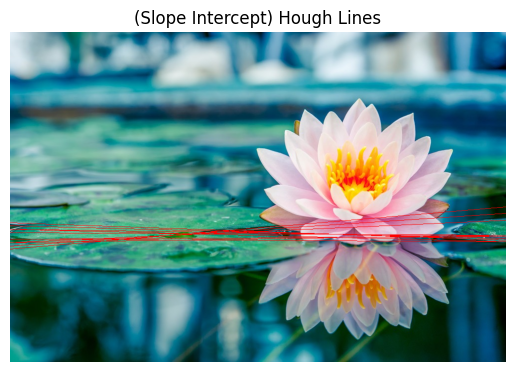

In [463]:
img, acc, m_vals, c_vals = hough_slope_intercept("lotus_image.jpeg")
draw_lines_mc(img, acc, m_vals, c_vals, threshold=0.9)


The slope–intercept Hough transform is computationally expensive because each edge pixel votes for many slope values. 
- As Vertical lines are difficult to represent, and runtime increases rapidly with accumulator resolution

### C2. Rho Theta Form

In [464]:
def hough_rho_theta(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 100, 200)

    h, w = edges.shape
    diag = int(np.sqrt(h*h + w*w))

    thetas = np.linspace(0, np.pi, 180)
    rhos = np.linspace(-diag, diag, 2*diag)

    accumulator = np.zeros((len(rhos), len(thetas)))

    ys, xs = np.where(edges > 0)

    for x, y in zip(xs, ys):
        for ti, theta in enumerate(thetas):
            rho = x*np.cos(theta) + y*np.sin(theta)
            ri = np.searchsorted(rhos, rho)
            if 0 <= ri < len(rhos):
                accumulator[ri, ti] += 1

    accumulator = accumulator / accumulator.max()
    return img, accumulator, rhos, thetas


In [465]:
def draw_lines_rho_theta(img, accumulator, rhos, thetas, threshold=0.6):
    out = img.copy()
    idx = np.where(accumulator > threshold)

    for ri, ti in zip(idx[0], idx[1]):
        rho = rhos[ri]
        theta = thetas[ti]

        a = np.cos(theta)
        b = np.sin(theta)

        x0 = a * rho
        y0 = b * rho

        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(out, (x1,y1), (x2,y2), (0,255,0), 1)

    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
    plt.title("(Rho Theta) Hough Lines")
    plt.axis('off')
    plt.show()


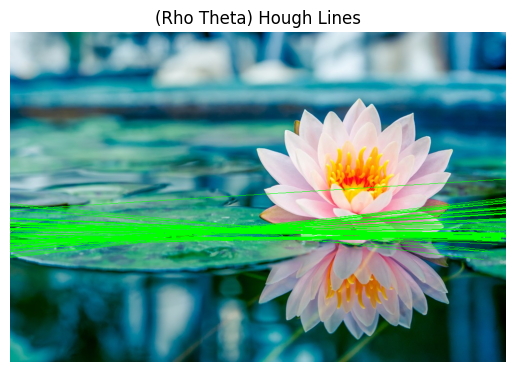

In [466]:
img, acc, rhos, thetas = hough_rho_theta("lotus_image.jpeg")
draw_lines_rho_theta(img, acc, rhos, thetas, threshold=0.6)


The ρ–θ Hough transform is significantly faster and more robust than the slope–intercept formulation, especially for vertical lines which is evident from both runtime and clarity of detected lines.